<div style="text-align: center;">
  
# 🧁 Limpeza e tratamento de dados de CGM (monitoramento contínuo de glicemia)

</div>

## 1. Carregando as bibliotecas

In [1]:
#%pip install missingno

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## 2. Extraindo e visualizando o dataframe; padronizando os nomes das variáveis

In [3]:
# Dataset extraído pelo RStudio através do repositório 
# https://rdrr.io/github/personalscience/psi-shiny-cgm/man/sample_libreview_df.html
df_a = pd.read_csv('./sample_libreview_df_raw.csv')
df_raw = df_a.copy()

In [4]:
'''
No atributo columns (do tipo índice) do objeto df_raw, nosso dataframe, iremos formatar
todos os seus elementos, isto é, os nomes das colunas. Para isso, utilizamos o acessor .str, 
que nos permite aplicar métodos de strings para todos os elementos do índice/vetor.
Os métodos utilizados são: 
- lower(): torna todos os caracteres minúsculos;
- strip(): remove espaços em branco das extremidades da string;
- replace(,): substituímos o elemento da esquerda, sempre que ele aparecer, pelo da 
direita. No nosso caso, trocamos um espaço em branco por nenhum espaço, e ":" por nenhum espaço.
'''

df_raw.columns = df_raw.columns.str.lower().str.strip().str.replace(' ', '').str.replace(':', '')
df_raw

,unnamed0,time,scan,hist,strip,value,food,user_id
0,1,2021-05-30 16:59:00,NaN,69.0,NaN,69.0,NaN,1234
1,2,2021-05-30 17:14:00,NaN,66.0,NaN,66.0,NaN,1234
2,3,2021-05-30 17:30:00,NaN,62.0,NaN,62.0,NaN,1234
3,4,2021-05-30 17:45:00,NaN,60.0,NaN,60.0,NaN,1234
4,5,2021-05-30 18:00:00,NaN,62.0,NaN,62.0,NaN,1234
...,...,...,...,...,...,...,...,...
3979,3980,2021-07-12 19:27:00,NaN,NaN,NaN,NaN,NaN,1234
3980,3981,2021-07-13 11:25:00,NaN,NaN,NaN,NaN,NaN,1234
3981,3982,2021-07-15 14:17:00,NaN,NaN,NaN,NaN,NaN,1234
3982,3983,2021-07-16 09:31:00,NaN,NaN,NaN,NaN,NaN,1234


## 3. Verificando a hierarquia entre 'value', 'strip', 'scan' e 'hist'

In [5]:
def value_herda_exclui(df, col_time='time', col_alvo='value', col1='strip', col2='scan', col3='hist'):
    """
    Preenche os NaNs de `col_alvo` com prioridade:
    1. Usa `col1` se disponível.
    2. Caso contrário, usa `col2`.
    3. Caso contrário, usa `col3`.
    """
    
    df = df.copy()
    
    # 0 = não foi preenchido por outra coluna, 1 foi por col1, 2 por col2 e 3 por col3.
    df['preenchido_por'] = 0

    # vetores (Series), onde: o primeiro tem valores True nos índices em que col_alvo é NaN; 
    # o segundo tem valores True onde col1 não é NaN
    cond1 = df[col_alvo].isna() & df[col1].notna() 
    # faço a substituição nessas posições
    df.loc[cond1, col_alvo] = df.loc[cond1, col1]
    df.loc[cond1, 'preenchido_por'] = 1

    # Faço o mesmo com as linhas restantes de col_alvo que continuam NaN, mas agora
    # comparando com os valores de col2 e col3
    cond2 = df[col_alvo].isna() & df[col2].notna()
    df.loc[cond2, col_alvo] = df.loc[cond2, col2]
    df.loc[cond2, 'preenchido_por'] = 2

    cond3 = df[col_alvo].isna() & df[col3].notna()
    df.loc[cond3, col_alvo] = df.loc[cond3, col3]
    df.loc[cond3, 'preenchido_por'] = 3

    # Agora, vamos ordenar por prioridade e eliminar duplicatas no tempo
    df = df.sort_values(by=[col_time, 'preenchido_por'])  # menor preenchido_por tem maior prioridade
    df = df.drop_duplicates(subset=col_time, keep='first').reset_index(drop=True)

    # Removo a coluna que indica de qual medição o value foi advindo
    df = df.drop(columns=['preenchido_por'])

    return df

df_raw = value_herda_exclui(df_raw)
df_raw

,unnamed0,time,scan,hist,strip,value,food,user_id
0,3883,2021-05-30 15:57:00,NaN,NaN,NaN,NaN,NaN,1234
1,3884,2021-05-30 16:58:00,NaN,NaN,NaN,NaN,NaN,1234
2,1,2021-05-30 16:59:00,NaN,69.0,NaN,69.0,NaN,1234
3,3885,2021-05-30 17:02:00,NaN,NaN,NaN,NaN,NaN,1234
4,2,2021-05-30 17:14:00,NaN,66.0,NaN,66.0,NaN,1234
...,...,...,...,...,...,...,...,...
3863,3559,2021-07-20 06:55:00,NaN,77.0,NaN,77.0,NaN,1234
3864,3560,2021-07-20 07:10:00,NaN,80.0,NaN,80.0,NaN,1234
3865,3561,2021-07-20 07:25:00,NaN,83.0,NaN,83.0,NaN,1234
3866,3562,2021-07-20 07:40:00,NaN,82.0,NaN,82.0,NaN,1234


## 4. Certificando os tipos de dados e removendo variáveis desnecessárias

In [6]:
# convertemoscoluna 'time' para o tipo datetime
df_raw['time'] = pd.to_datetime(df_raw['time'], errors = 'coerce') 
# a coluna 'value' se torna numérica
df_raw['value'] = pd.to_numeric(df_raw['value'], errors = 'coerce') 

# OBS: errors = 'coerce' faz com que elementos que não estejam num formato válido para
# serem convertidos para datetime retornem NaT, e os que não possam ser convertidos para
# int ou float (numérico) retornem NaN.


In [7]:
# Eliminando as colunas que não serão utilizadas
df_raw = df_raw.drop(columns=['unnamed0', 'strip', 'hist', 'scan', 'food', 'user_id'])

df_raw

,time,value
0,2021-05-30 15:57:00,NaN
1,2021-05-30 16:58:00,NaN
2,2021-05-30 16:59:00,69.0
3,2021-05-30 17:02:00,NaN
4,2021-05-30 17:14:00,66.0
...,...,...
3863,2021-07-20 06:55:00,77.0
3864,2021-07-20 07:10:00,80.0
3865,2021-07-20 07:25:00,83.0
3866,2021-07-20 07:40:00,82.0


## 5. Eliminando os valores nulos e absurdos

In [8]:
# Contagem de quantos valores nulos (NaN ou NaT) temos em cada coluna de df_raw
# df_raw.isnull() retorna um dataframe com True e False em cada célula. True, se a célula tem
# valor NaN ou NaT, e False em caso contrário. O método sum(axis = 0) soma a quantidade de cada coluna.
# Como True corresponde ao valor 1 e False a 0, teremos assim a soma dos valores nulos.

print('Valores nulos antes: \n')
print(df_raw.isnull().sum(axis = 0))

Valores nulos antes: 

time      1
value    97
dtype: int64


In [9]:
# Excluindo as linhas em que 'time' ou 'value' tem valor nulo
df_raw = df_raw.dropna(subset=['time','value'])

# Excluindo as linhas em que 'value' tem um possível ruído
df_raw = df_raw[(df_raw['value'] > 0) & (df_raw['value'] < 500)]

# Organizando o dataframe por 'time' crescente, e resetando os índices, já que
# ao excluirmos linhas, a linha com o índice é excluída. Agora, temos índices ordenados e
# sequenciados novamente de 0 ao fim do dataframe.
df_raw = df_raw.sort_values(by='time').reset_index(drop=True) 

# Esse é o dataframe apenas com dados medidos
df_raw 

,time,value
0,2021-05-30 16:59:00,69.0
1,2021-05-30 17:14:00,66.0
2,2021-05-30 17:30:00,62.0
3,2021-05-30 17:45:00,60.0
4,2021-05-30 18:00:00,62.0
...,...,...
3765,2021-07-20 06:55:00,77.0
3766,2021-07-20 07:10:00,80.0
3767,2021-07-20 07:25:00,83.0
3768,2021-07-20 07:40:00,82.0


## 6. Verificando se há grandes hiatos de tempo em 'time' e preenchendo-os

In [10]:
def preencher_hiatos(df, col_time='time', col_val='value', hiato=3, x='15min', st=15, e=15):
    """
    Preenche hiatos (lacunas) maiores ou iguais a hiato no DataFrame,
    inserindo linhas com timestamps intermediários e valores NaN.

    Parâmetros:
    -----------
    df : pd.DataFrame
        DataFrame original contendo ao menos as colunas de tempo e valor.
    col_time : str, default 'time'
        Nome da coluna com timestamps (deve ser datetime).
    col_val : str, default 'value'
        Nome da coluna com os valores (numéricos, pode conter NaNs).
    hiato : float, default 3
        Mínimo intervalo em horas para considerar um hiato para preenchimento.
    x : str, default '15min'
        Frequência para preenchimento dos timestamps intermediários.
    st : float, default 15
        Determina após quantos minutos do valor antes do hiato iremos colocar nosso primeiro preenchimento
    e : float, default 15
        Determina a distância mínima que o último preenchimento pode estar do primeiro timestamp após o hiato
    Retorna:
    --------
    pd.DataFrame
        Novo DataFrame com os hiatos preenchidos com linhas contendo NaN em col_val,
        ordenado por tempo e com índice resetado.
    """

    df = df.copy()
    
    # criando uma coluna que mede a diferença em horas entre um elemento de 'col_time' e o elemento 'anterior'
    df['diff_horas'] = (df[col_time].diff().dt.total_seconds())/(60 * 60)

    # preencheremos somente hiatos maiores ou iguais a {hiato}

    # índices dos elementos que estão imediatamente antes de cada hiato
    inds_i = df[df['diff_horas'] >= hiato].index - 1
    # índices dos elementos que estão ao fim de cada hiato
    inds_f = df[df['diff_horas'] >= hiato].index

    # Número de hiatos:
    print(f'O total de hiatos de {hiato} horas encontrado foi:', len(inds_i), '\nIremos preenchê-los com mais marcações.\n')

    # Novas linhas, com respectivos datatimes, que iremos adicionar ao df após o processo.
    # Começamos com uma lista vazia.
    linhas = []

    # Pegaremos cada índice de início e fim de hiato, acessaremos o elemento correspondente em 'col_time' e
    # faremos o preenchimento desse hiato

    for i in range(len(inds_i)):
        inicio = inds_i[i] # índice início hiato (rodaremos a lista de índices)
        fim = inds_f[i] # índice fim hiato

        start_time = df.loc[inicio, col_time] # acessando df na coluna 'col_time' na posição início
        end_time = df.loc[fim, col_time] # na posição fim

        # Lista com os timestamps criados
        range_time = pd.date_range(start=start_time + pd.Timedelta(minutes=st), # começaremos o preenchimento 15 minutos após início do hiato
                                            end=end_time - pd.Timedelta(minutes=e), # terminaremos no máximo até 15 minutos antes do fim do hiato
                                            freq=x) # preencheremos de 15 em 15 minutos esse hiato
        
        # Colocaremos cada um desses timestamps dentro do dicionário com as chaves 'time'
        # e 'value', essas últimas recebendo NaN como valores. O objeto 'linhas' receberá esse dicionário.
        for timestamp in range_time:
            linhas.append({col_time: timestamp, col_val: np.nan}) 


    # O dicionário 'linhas' se torna o dataframe 'df_linhas'
    df_linhas = pd.DataFrame(linhas)

    # Concatenamos o dataframe df, mas sem a coluna diff_horas (agora desnecessária), com
    # o dataframe df_linhas, que tem as mesmas colunas (value e time).
    # ignore_index = True evita índices duplicados (exemplo: o índice 2 em ambos os dataframes), 
    # e reseta o índice do dataframe concatenado, para que vá de 0 até o último elemento da lista, de maneira sequencial
    df = pd.concat([df.drop(columns=['diff_horas']), df_linhas], ignore_index=True)

    # Ordenamos o dataframe por 'time' crescente e mais uma vez resetamos os índices (a redundância
    # se deve apenas à uma questão de organização)
    df = df.sort_values(by=col_time).reset_index(drop=True)

    return df

df_tempos = preencher_hiatos(df_raw)

# Esse é o dataframe com os dados originais e novas estampas de tempo, mas sem preencher os valores
# correspondentes a elas

df_tempos



O total de hiatos de 3 horas encontrado foi: 13 
Iremos preenchê-los com mais marcações.



,time,value
0,2021-05-30 16:59:00,69.0
1,2021-05-30 17:14:00,66.0
2,2021-05-30 17:30:00,62.0
3,2021-05-30 17:45:00,60.0
4,2021-05-30 18:00:00,62.0
...,...,...
4863,2021-07-20 06:55:00,77.0
4864,2021-07-20 07:10:00,80.0
4865,2021-07-20 07:25:00,83.0
4866,2021-07-20 07:40:00,82.0


## 7. Atribuindo valores aos novos timestamps criados

In [11]:
from scipy.stats import truncnorm

# Função para gerar valores de uma normal truncada (com limite inferior e superior)
def amost_norm_tr(mu, sigma, low=0, high=500):
    a, b = (low - mu) / sigma, (high - mu) / sigma
    return truncnorm.rvs(a, b, loc=mu, scale=sigma)

def imp_est_value(df, col_time='time', col_val='value', n=20):
     
    """
    Imputa valores ausentes em uma coluna de medições temporais usando normal truncada.

    A imputação é feita individualmente para cada timestamp com valor ausente,
    baseado na média e desvio padrão calculados a partir das n vizinhas observações
    mais próximas no tempo (n/2 anteriores e n/2 posteriores), que:
      - possuem o mesmo valor da hora (0 a 23) do dado ausente,
      - possuem valores observados (não NaN),
      - e são distintas do próprio dado ausente.

    Para garantir independência estatística e evitar viés, a média e desvio padrão
    são sempre calculados apenas com os dados originais observados (não imputados),
    mesmo durante o processo de múltiplas imputações.

    Parâmetros:
    -----------
    df : pandas.DataFrame
        DataFrame contendo as colunas de tempo e valores a imputar.

    col_time : str, default 'time'
        Nome da coluna no DataFrame que contém as datas e horários completos (formato datetime).

    col_val : str, default 'value'
        Nome da coluna contendo os valores numéricos onde podem existir dados ausentes (NaN).

    n : int, default 20
        Número total de vizinhos temporais a considerar para cálculo de média e desvio padrão.
        A função busca n//2 observações anteriores e n//2 posteriores mais próximas no tempo.

    Retorna:
    --------
    pandas.DataFrame
        Cópia do DataFrame original com os valores ausentes imputados.
    """

    df = df.copy()

    # Certificar que col_time está no formato datetime
    df[col_time] = pd.to_datetime(df[col_time])

    # criar a coluna _hora
    df['_hora'] = df[col_time].dt.hour

    # garante ordenação pelo tempo
    df.sort_values(by=col_time, inplace=True)

    # Base fixa só com dados originais (não imputados)
    df_original = df[df[col_val].notna()].copy()

    # coluna que vai dizer se o valor foi estimado ou não
    df['is_imputed'] = False

    # indíces de elementos de col_val com valor NaN
    inds_nan = df[df[col_val].isna()].index
    
    # Número de medições reais à esquerda e à direita
    metade = n // 2

    for ind in inds_nan:
        timestamp_faltante = df.at[ind, col_time] # selecionar o timestamp sem valor
        hora_faltante = df.at[ind, '_hora'] # selecionar a hora do timestamp sem valor

        # Filtrar dados com a mesma hora e valores não ausentes
        df_valid = df_original[df_original['_hora'] == hora_faltante]

        # Vizinhos anteriores (com timestamp < faltante), pega os mais próximos
        anteriores = df_valid[df_valid[col_time] < timestamp_faltante].tail(metade)

        # Vizinhos posteriores (com timestamp > faltante), pega os mais próximos
        posteriores = df_valid[df_valid[col_time] > timestamp_faltante].head(metade)

        # Junta os vizinhos do dado faltante
        amostras = pd.concat([anteriores, posteriores])

        if len(amostras) >= 2:
            # Distância em segundos até o timestamp ausente
            amostras['delta'] = (amostras[col_time] - timestamp_faltante).dt.total_seconds().abs()

            # Peso inversamente proporcional ao quadrado da distância (suavização forte)
            amostras['peso'] = 1 / (1 + amostras['delta'])**2

            # Extrai valores e pesos
            valores = amostras[col_val].values
            pesos = amostras['peso'].values

            # Média ponderada
            mu_ponderado = np.average(valores, weights=pesos)

            # Variância e desvio padrão ponderados
            var_ponderada = np.average((valores - mu_ponderado) ** 2, weights=pesos)
            sigma_ponderado = np.sqrt(var_ponderada)

            # Imputa o valor usando normal truncada
            imputado = amost_norm_tr(mu_ponderado, sigma_ponderado)
            df.at[ind, col_val] = imputado
            df.at[ind, 'is_imputed'] = True  # Marca como imputado

    # Remove coluna auxiliar
    df.drop(columns=['_hora'], inplace=True)

    return df

df_raw = imp_est_value(df_raw)
df_est = imp_est_value(df_tempos)

# Novo dataframe, com os valores medidos e os valores estimados
df_est



,time,value,is_imputed
0,2021-05-30 16:59:00,69.0,False
1,2021-05-30 17:14:00,66.0,False
2,2021-05-30 17:30:00,62.0,False
3,2021-05-30 17:45:00,60.0,False
4,2021-05-30 18:00:00,62.0,False
...,...,...,...
4863,2021-07-20 06:55:00,77.0,False
4864,2021-07-20 07:10:00,80.0,False
4865,2021-07-20 07:25:00,83.0,False
4866,2021-07-20 07:40:00,82.0,False


## 8. Granulação de 'time' em 'date', 'hour', 'hour_minute', 'weekday' e 'hour_cont'

In [12]:
def granular(df, col_time='time', col_val='value', imp='is_imputed'):
    """
    Adiciona colunas derivadas de tempo para análise estatística e manipulação temporal.

    Parâmetros:
    -----------
    df : pd.DataFrame
        DataFrame com uma coluna datetime.
    col_time : str, default 'time'
        Nome da coluna que contém timestamps (deve ser do tipo datetime ou conversível).
    col_value : str, default 'value'
        Nome da coluna que contém medições.
    imp : str, default 'is_imputed'
        Nome da coluna que informa se o valor correspondente foi estimado ou não.
    Retorna:
    --------
    pd.DataFrame
        DataFrame com as colunas adicionais:
            - 'date' : data (sem horário)
            - 'hour' : hora inteira
            - 'hour_minute' : string com hora e minuto no formato HH:MM
            - 'weekday' : nome do dia da semana
            - 'hour_cont' : hora com fração decimal (ex: 14.25 para 14:15)
    """
    df = df.copy()
    df[col_time] = pd.to_datetime(df[col_time])
    df['date'] = df[col_time].dt.date
    df['hour'] = df[col_time].dt.hour
    df['hour_minute'] = df[col_time].dt.strftime('%H:%M')
    df['weekday'] = df[col_time].dt.day_name()
    df['hour_cont'] = (df[col_time].dt.hour + df[col_time].dt.minute / 60).round(2)

    colunas_ordenadas = [col_time, 'date', 'hour_minute', col_val, imp, 'weekday', 'hour', 'hour_cont']
    df = df[colunas_ordenadas]
    return df

df_raw = granular(df_raw)
df_est = granular(df_est)

df_est.to_csv("est.csv", index=False)

## 9. Organização final das tabelas

In [13]:
df_raw

,time,date,hour_minute,value,is_imputed,weekday,hour,hour_cont
0,2021-05-30 16:59:00,2021-05-30,16:59,69.0,False,Sunday,16,16.98
1,2021-05-30 17:14:00,2021-05-30,17:14,66.0,False,Sunday,17,17.23
2,2021-05-30 17:30:00,2021-05-30,17:30,62.0,False,Sunday,17,17.50
3,2021-05-30 17:45:00,2021-05-30,17:45,60.0,False,Sunday,17,17.75
4,2021-05-30 18:00:00,2021-05-30,18:00,62.0,False,Sunday,18,18.00
...,...,...,...,...,...,...,...,...
3765,2021-07-20 06:55:00,2021-07-20,06:55,77.0,False,Tuesday,6,6.92
3766,2021-07-20 07:10:00,2021-07-20,07:10,80.0,False,Tuesday,7,7.17
3767,2021-07-20 07:25:00,2021-07-20,07:25,83.0,False,Tuesday,7,7.42
3768,2021-07-20 07:40:00,2021-07-20,07:40,82.0,False,Tuesday,7,7.67


In [14]:
df_est

,time,date,hour_minute,value,is_imputed,weekday,hour,hour_cont
0,2021-05-30 16:59:00,2021-05-30,16:59,69.0,False,Sunday,16,16.98
1,2021-05-30 17:14:00,2021-05-30,17:14,66.0,False,Sunday,17,17.23
2,2021-05-30 17:30:00,2021-05-30,17:30,62.0,False,Sunday,17,17.50
3,2021-05-30 17:45:00,2021-05-30,17:45,60.0,False,Sunday,17,17.75
4,2021-05-30 18:00:00,2021-05-30,18:00,62.0,False,Sunday,18,18.00
...,...,...,...,...,...,...,...,...
4863,2021-07-20 06:55:00,2021-07-20,06:55,77.0,False,Tuesday,6,6.92
4864,2021-07-20 07:10:00,2021-07-20,07:10,80.0,False,Tuesday,7,7.17
4865,2021-07-20 07:25:00,2021-07-20,07:25,83.0,False,Tuesday,7,7.42
4866,2021-07-20 07:40:00,2021-07-20,07:40,82.0,False,Tuesday,7,7.67


<div style="text-align: center;">
  
# 🔍 Análise Exploratória de Dados

</div>

In [15]:
print('Quantidade de linhas e colunas:\n', df_est.shape, '\n\n---\n')
print('Colunas presentes:\n', df_est.columns, '\n---\n')
print('Tipo de dados:\n', df_est.dtypes, '\n\n---\n')
print('Quantidade de dados únicos:\n', df_est.nunique())

Quantidade de linhas e colunas:
 (4868, 8) 

---

Colunas presentes:
 Index(['time', 'date', 'hour_minute', 'value', 'is_imputed', 'weekday', 'hour',
       'hour_cont'],
      dtype='object') 
---

Tipo de dados:
 time           datetime64[ns]
date                   object
hour_minute            object
value                 float64
is_imputed               bool
weekday                object
hour                    int32
hour_cont             float64
dtype: object 

---

Quantidade de dados únicos:
 time           4868
date             52
hour_minute    1391
value          1220
is_imputed        2
weekday           7
hour             24
hour_cont      1391
dtype: int64


In [16]:
df_est['value'].describe().round(1)

count    4868.0
mean       80.1
std        17.3
min        33.1
25%        70.0
50%        78.0
75%        87.0
max       223.0
Name: value, dtype: float64

Quantidade de aparições dos valores medidos para glucose no fluido intersticial (mg/dL)


Text(0.5, 0, 'Glicose (mg/dL)')

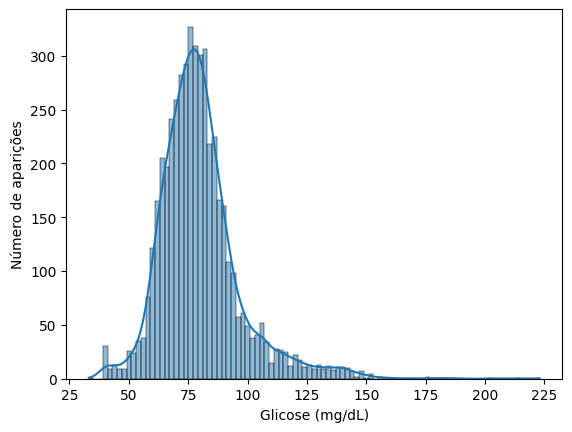

In [17]:
print('Quantidade de aparições dos valores medidos para glucose no fluido intersticial (mg/dL)')
sns.histplot(df_est['value'], kde=True)
plt.ylabel('Número de aparições')
plt.xlabel('Glicose (mg/dL)')

Quantidade de medições por dia da semana


Text(0.5, 0, 'Dia da semana')

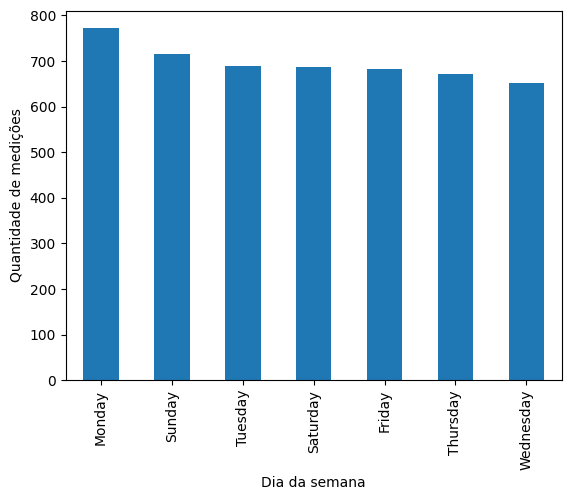

In [18]:
print('Quantidade de medições por dia da semana')
df_est['weekday'].value_counts().plot.bar()
plt.ylabel('Quantidade de medições')
plt.xlabel('Dia da semana')

Média das medições nos dias em que houve aferição


Text(0.5, 0, 'Data')

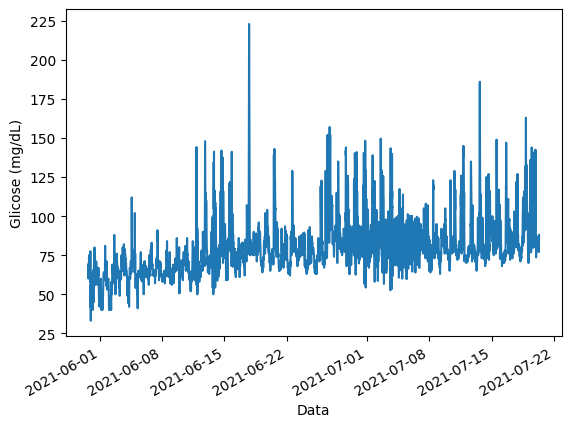

In [19]:
print('Média das medições nos dias em que houve aferição')
df_est.groupby('time')['value'].mean().plot()
plt.ylabel('Glicose (mg/dL)')
plt.xlabel('Data')

Número de medições por data


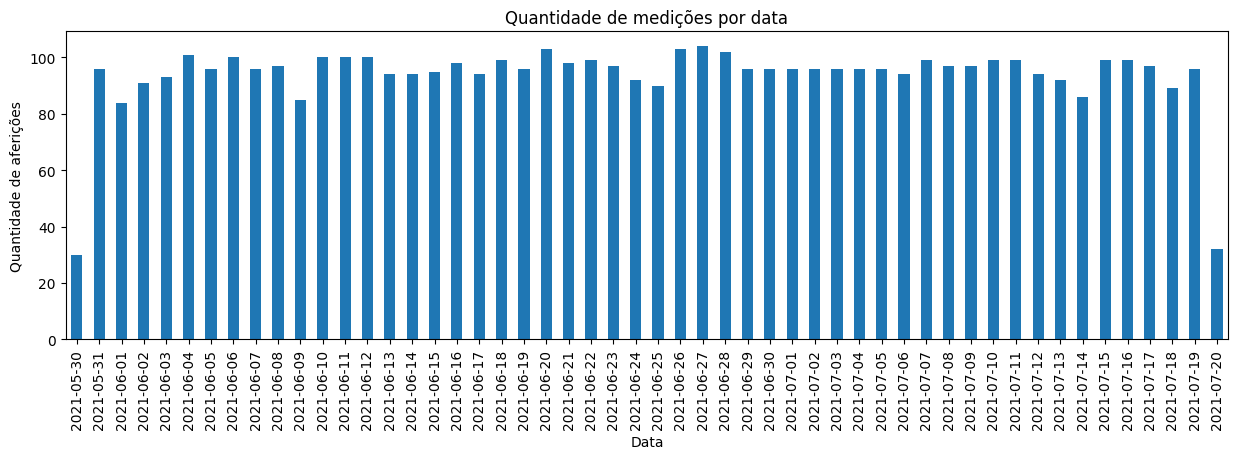

In [20]:
print('Número de medições por data')
df_est.groupby('date').size().plot(kind='bar', figsize=(15, 4), title='Quantidade de medições por data')
plt.ylabel('Quantidade de aferições')
plt.xlabel('Data')
plt.show()

Quantidade de medições por hora


Text(0.5, 0, 'Hora do dia')

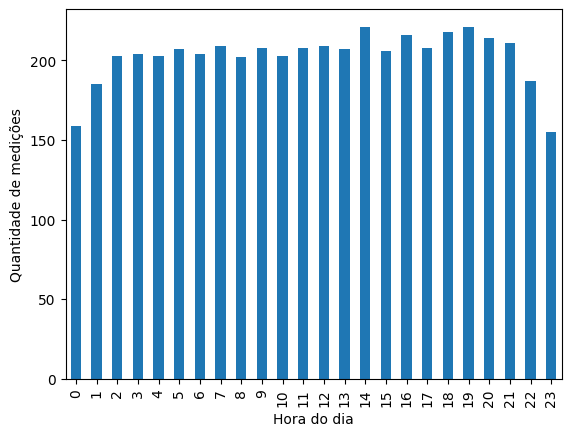

In [29]:
print('Quantidade de medições por hora')
contagem_horas_ord = df_est['hour'].value_counts().sort_index()
contagem_horas_ord.plot.bar()
plt.ylabel('Quantidade de medições')
plt.xlabel('Hora do dia')

## 1. Há relação entre o valor da glicemia (value) e o horário do dia (time)? Em quais horas do dia há maiores picos de glicemia? Em quais horas do dia há menores valores de glicemia? 


In [ ]:
# Valores de média, mínimo e máximo valores de glicemia (mg/dL) por hora do dia
df_est.groupby('hour')['value'].agg(['mean', 'min', 'max']).round(1)

In [ ]:
# Gráfico da média de glicemia por hora do dia 
media_por_hora = df_est.groupby('hour')['value'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=media_por_hora.index, y=media_por_hora.values)
plt.title('Média de glicemia por hora do dia')
plt.xlabel('Hora do dia')
plt.ylabel('Glicemia (mg/dL)')
plt.grid(True)
plt.xticks(range(24))
plt.show()

# 2. Nos dados analisados, qual a porcentagem do tempo o paciente está dentro, acima ou abaixo dos valores de referência ideais? 

##### Valores ideais:
##### TIR time in range: ≥ 70% do tempo entre 70-180 mg/dL
##### TBR time below range: < 4% do tempo abaixo de 70 mg/dL
##### TBR time very below range: < 1% abaixo de 54 mg/dL
##### TAR time above range: < 25% acima de 180 mg/dL

In [ ]:
total = len(df_raw)
tar = len(df_raw[df_raw['value'] > 180]) / total * 100
tir = len(df_raw[(df_raw['value'] >= 70) & (df_raw['value'] <= 180)]) / total * 100
tbr = len(df_raw[df_raw['value'] < 70]) / total * 100
tvbr = len(df_raw[df_raw['value'] < 54]) / total * 100

In [ ]:
tar_check = '✔️' if tar < 25 else '❌'
tir_check = '✔️' if tir >= 70 else '❌'
tbr_check = '✔️' if tbr < 4 else '❌'
tvbr_check = '✔️' if tvbr < 1 else '❌'

In [ ]:
print(f'| TAR time above range      | {tar:.1f}%  | < 25% acima de 180 mg/dL           | {tar_check} |')
print(f'| TIR time in range         | {tir:.1f}% |  ≥ 70% do tempo entre 70-180 mg/dL | {tir_check} |')
print(f'| TBR time below range      | {tbr:.1f}% | < 4% do tempo abaixo de 70 mg/dL   | {tbr_check} |')
print(f'| TBR time very below range | {tvbr:.1f}%  | < 1% abaixo de 54 mg/dL            | {tvbr_check} |')

# 3. Dentro do período de medição, houve algum dia em que a média de glicemia destoou muito do normal? Em quais momentos houve episódios de hiper (>180mg/dL) e hipoglicemia? (<70mg/dL)

In [ ]:
from matplotlib.colors import ListedColormap, BoundaryNorm

mapa_medicoes = df_raw[['value']]
mapa_medicoes = mapa_medicoes.T

faixas = [0, 70, 180, df_raw['value'].max() + 1]

# Cores suaves e harmônicas:
colors = ['#7DA6C1', '#A3C293', '#D46256']
cmap = ListedColormap(colors)
norm = BoundaryNorm(faixas, cmap.N)

# Plot
plt.figure(figsize=(20, 2))
sns.heatmap(mapa_medicoes, cmap=cmap, norm=norm, cbar_kws={'label': 'Glicose (mg/dL)'})
plt.yticks([], [])
plt.xlabel("Leituras")
plt.title("Mapa de calor com destaque para medições individuais acima de 180 e abaixo de 70")
plt.show()


# 4. Quão rápido a curva de glicemia tende a voltar para os valores de referência ideais? Há alguma variável que influencia o tempo de retorno?

# 5. Há diferença significativa da média de glicemia entre dias da semana? (dias úteis, fins de semana)

In [ ]:
from matplotlib.colors import ListedColormap, BoundaryNorm

tabela = df_raw.pivot_table(index='hour', columns='weekday', values='value', aggfunc='mean')
max_val = df_raw['value'].max()

colors = ['#E99A8B', '#A3C293', '#D46256'] 
glucose_range = [0, 70, 140, max_val + 1]

cmap = ListedColormap(colors)
norm = BoundaryNorm(glucose_range, cmap.N)

plt.figure(figsize=(6, 6))
sns.heatmap(tabela, annot=True, fmt=".1f", cmap=cmap, norm=norm, cbar_kws={'label': 'Glicose (mg/dL)'})
plt.title("Glicose média por hora do dia e por dia da semana")
plt.ylabel("Hora do dia")
plt.xlabel("Dia da semana")
plt.show()

In [ ]:
media_por_dia = df_raw.groupby('weekday')['value'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
]).reset_index()

mapa_mediageral = pd.DataFrame([media_por_dia['value'].values], columns=media_por_dia['weekday'].values)

plt.figure(figsize=(8, 2))
sns.heatmap(mapa_mediageral, annot=True, fmt=".1f", cmap="crest", cbar_kws={'label': 'Glicose média (mg/dL)'})
plt.title("Média de glicose no fluido intersticial por dia da semana")
plt.yticks([], []) 
plt.xlabel("Dia da semana")
plt.show()


# 6. Há variação de glicemia significativa durante o período noturno e durante a manhã (4h-8h)? (dawn phenomenon)

In [ ]:
# Gráfico da média de glicemia por hora do dia 
media_por_hora = df_raw.groupby('hour')['value'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=media_por_hora.index, y=media_por_hora.values)
plt.title('Média de glicemia por hora do dia')
plt.xlabel('Hora do dia')
plt.ylabel('Glicemia (mg/dL)')
plt.grid(True)
plt.xticks(range(24))
plt.show()

# 7. Qual a glicemia média geral do período analisado?

In [ ]:
media_global = df_raw['value'].mean()
media_check = '✔️' if media_global > 70 and media_global < 180 else '❌'
print('Média geral:', media_global, media_check)

# 8. Qual o desvio padrão ou coeficiente de variação (CV%) da glicemia?

# 9. Quais dias em que houve mais instabilidade (maior variação)?

# 10. Há consistência nos dados? É possível prever quais horas do dia haverá oscilações significativas?

# 11. Há alguma diferença entre a média da primeira e última metade da amostra? Houve alguma diferença no controle ao longo do mês ou permaneceu constante?

In [ ]:
# 12. Número e duração média dos episódios de hipoglicemia e hiperglicemia
# 13. Velocidade média de subida e queda da glicemia
# 14. Tempo em hipoglicemia noturna (00h–6h)
# 17. Predição simples com regressão ou modelo de baseline

# Predição com regressão linear

In [ ]:
#%pip install scikit-learn

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
x = df_raw[['hour']]
y = df_raw['value']

In [ ]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
modelo = LinearRegression()
modelo.fit(x_treino, y_treino)


In [ ]:
y_pred = modelo.predict(x_teste)
rmse = np.sqrt(mean_squared_error(y_teste, y_pred))

print("Coeficiente angular (slope):", modelo.coef_[0])
print("Intercepto:", modelo.intercept_)
print("R²:", r2_score(y_teste, y_pred))
print("RMSE:", rmse)

In [ ]:
plt.scatter(x_teste, y_teste, color='gray', label='Real')
plt.plot(x_teste, y_pred, color='blue', linewidth=2, label='Previsão')
plt.title('Previsão da glicemia com base na hora do dia')
plt.xlabel('Hora do dia')
plt.ylabel('Glicemia (mg/dL)')
plt.legend()
plt.grid(True)
plt.show()